In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [3]:
T1=27.4
T2=0.025
omega1=0.02
phi1=1.53
R1=146.9
R2=0.033
omega2=0.02
phi2=1.99

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=0.3
B=1.31
C=-2.4

b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1095 #1/365
R_L = 200
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

In [4]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

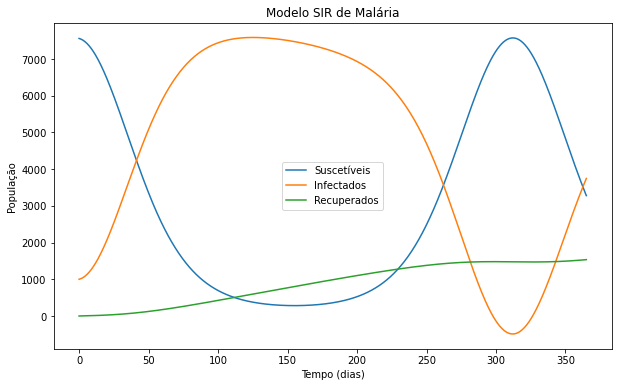

In [5]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [6]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

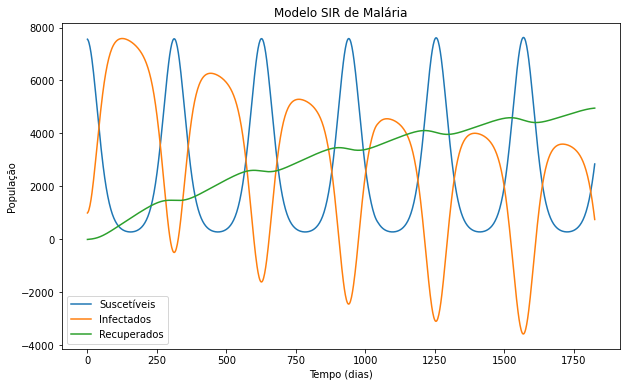

In [7]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

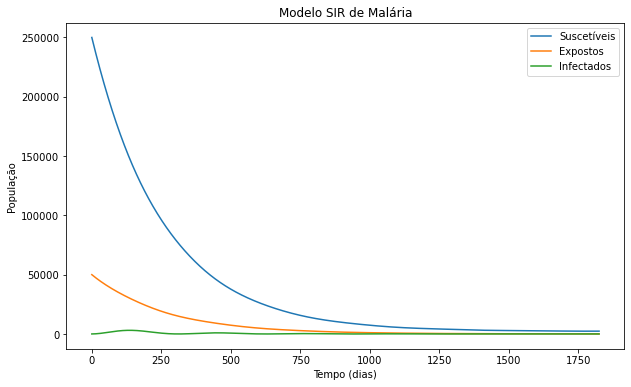

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

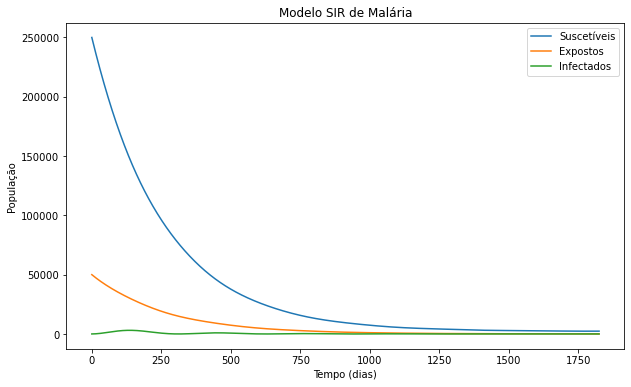

In [9]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [10]:
A

0.300000000000000

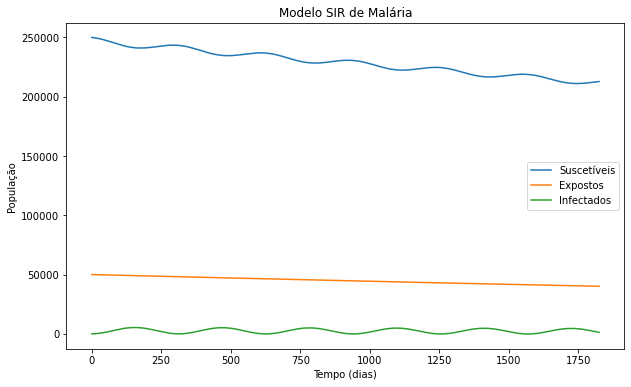

In [11]:
#Testes: A=-0.5, A=0, A=1, A=2, A=3, A=5, A=10, A=11

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 11, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [12]:
S_M[0]+E_M[0]+I_M[0]

300000.0

In [13]:
S_M[-1]+E_M[-1]+I_M[-1]

254201.2809776521

In [14]:
B

1.31000000000000

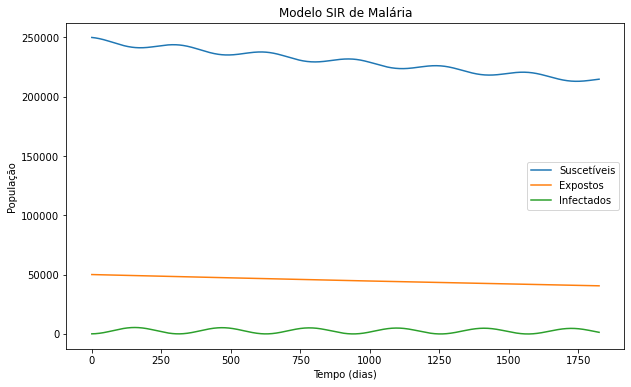

In [15]:
#Testes: B=-5, B=2, B=5, B=15

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 11, 15, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [16]:
S_M[-1]+E_M[-1]+I_M[-1]

256568.7520881999

É possível notar que aumentar o B faz bem menos efeito que aumentar o A

In [17]:
C

-2.40000000000000

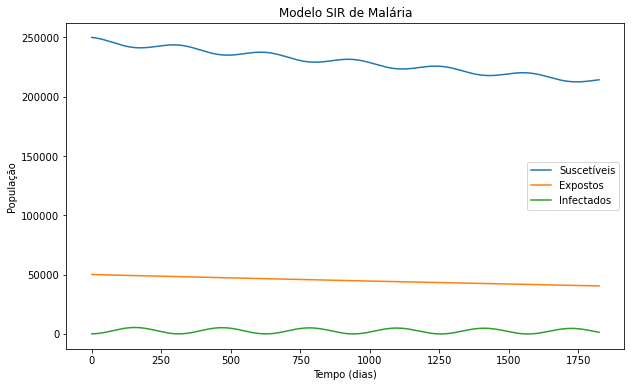

In [18]:
#Testes: C=-100, C=-25, C=5

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 11, 15, -100, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [19]:
S_M[-1]+E_M[-1]+I_M[-1]

255970.08845141303

In [20]:
A

0.300000000000000

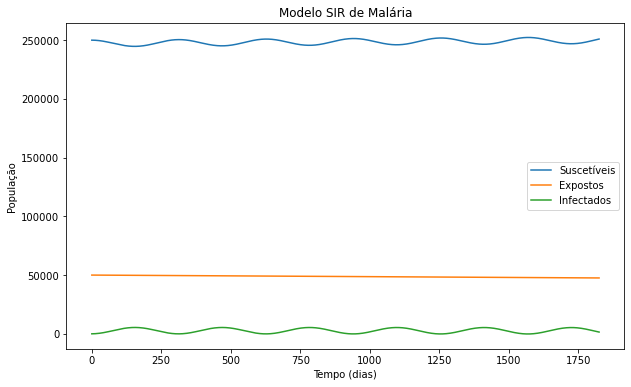

In [21]:
#Testes: A=20, A=25, A=35, A=45, A=60, A=55, A=50, A=48, A=49, A=48.5, A=48.3, A=48.1, 48.2, A=48.17725

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 48.17725, 15, -100, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [22]:
S_M[-1]+E_M[-1]+I_M[-1]

300000.0303032201

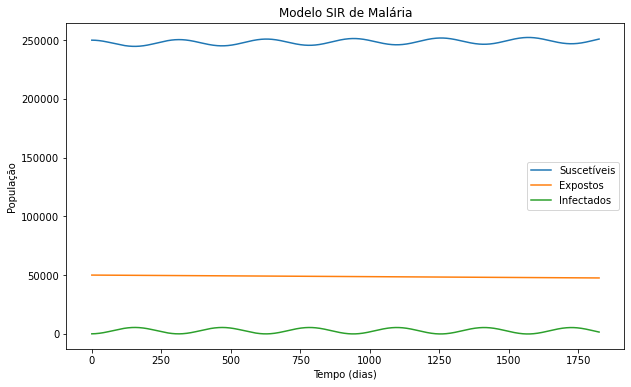

In [23]:
#Testes: B=-10, B=-5, B=5, B=10, B=12.5, B=13.5, B=14.5, B=14.75, B=14.95, B=14.975, B=14.99, B=14.995, B=14.9975, B=14.99725

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 48.17725, 14.99725, -100, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [24]:
S_M[-1]+E_M[-1]+I_M[-1]

300000.0000619894

In [25]:
print(f'R1={R1}, R2={R2}, omega2={omega2}, phi2={phi2}')

R1=146.900000000000, R2=0.0330000000000000, omega2=0.0200000000000000, phi2=1.99000000000000


In [26]:
A=48.17725
B=14.99725
C=-100

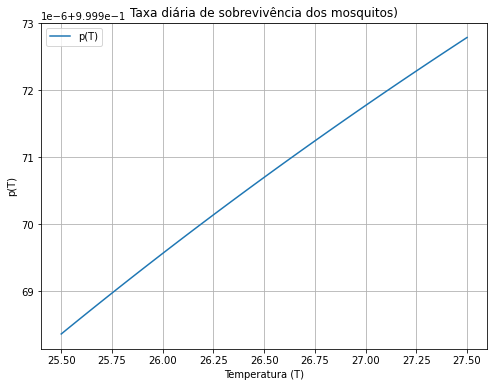

In [27]:
# Crie um intervalo de valores para a temperatura T
T_values = np.linspace(25.5, 27.5, 100)  # Intervalo de 10 a 40, com 100 pontos

# Calcule os valores correspondentes de p(T) para cada valor de T
p_values = np.exp(-1 / (A * T_values**2 + B * T_values + C))

# Plote o gráfico de p(T)
plt.figure(figsize=(8, 6))
plt.plot(T_values, p_values, label='p(T)')
plt.xlabel('Temperatura (T)')
plt.ylabel('p(T)')
plt.title('Taxa diária de sobrevivência dos mosquitos)')
plt.legend()
plt.grid(True)
plt.show()

<>:9: DeprecationWarning: invalid escape sequence \m
<>:11: DeprecationWarning: invalid escape sequence \m
<>:9: DeprecationWarning: invalid escape sequence \m
<>:11: DeprecationWarning: invalid escape sequence \m
<>:9: DeprecationWarning: invalid escape sequence \m
<>:11: DeprecationWarning: invalid escape sequence \m
<ipython-input-28-6a84b7aed4b4>:9: DeprecationWarning: invalid escape sequence \m
  plt.plot(T_values, mu_values, label='\mu(T)')
<ipython-input-28-6a84b7aed4b4>:11: DeprecationWarning: invalid escape sequence \m
  plt.ylabel('\mu(T)')


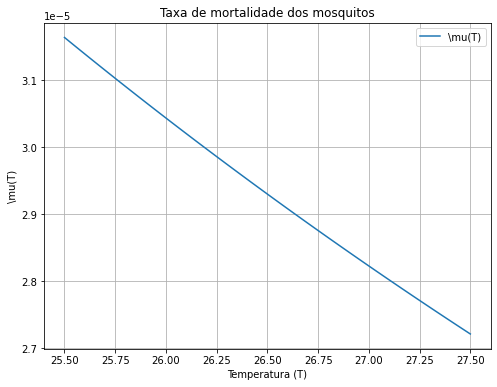

In [28]:
# Intervalo de valores para a temperatura T
T_values = np.linspace(25.5, 27.5, 100) 

# Calcule os valores correspondentes de \mu(T) para cada valor de T
mu_values = [-log(np.exp(-1 / (A * T**2 + B * T + C))) for T in T_values]

# Plote o gráfico de \mu(T)
plt.figure(figsize=(8, 6))
plt.plot(T_values, mu_values, label='\mu(T)')
plt.xlabel('Temperatura (T)')
plt.ylabel('\mu(T)')
plt.title('Taxa de mortalidade dos mosquitos')
plt.legend()
plt.grid(True)
plt.show()

Corrigindo para usar dados atualizados de temperatura e precipitação:

In [29]:
R1= 250.083 #146.9
R2= 0.565
omega2= 0.018
phi2=1.5

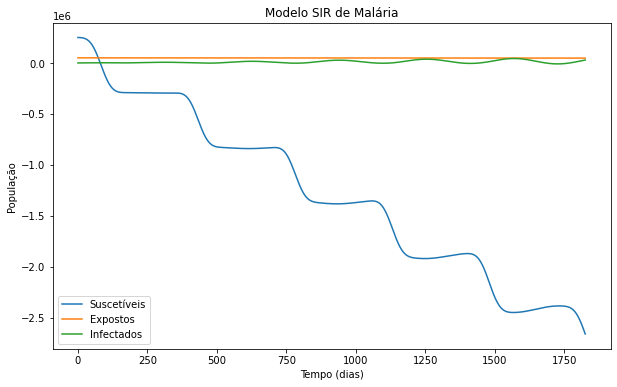

In [30]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 48.17725, 14.99725, -100, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

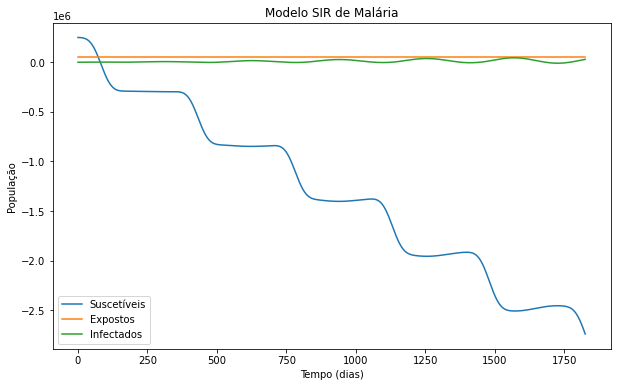

In [31]:
# Testes: A= -0.5, 0.5, 0, 0.2,-0.2

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -200, 1, -1, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [32]:
A=-0.03
B=1.31
C=-4.4

T1= 26.4 
T2= 0.025
omega1= 0.0175
phi1=-1.5

R1= 250.083 #146.9
R2= 0.565
omega2= 0.018
phi2=1.5

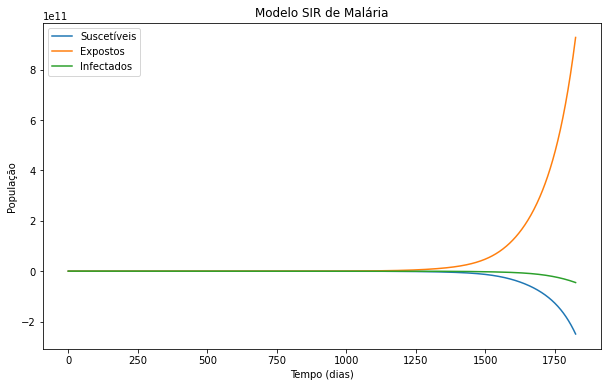

In [33]:
# A=A0, -0.5, -0.7, 1, 0.5, 0.75, -0.1, -0.2, -0.3

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -0.2, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [34]:
S_M[0]

250000.0

In [35]:
S_M[-1]

-249528116446.397

In [36]:
S_M

array([ 2.50000000e+05,  2.54057934e+05,  2.58151892e+05,  2.62273564e+05,
        2.66413277e+05,  2.70559840e+05,  2.74700556e+05,  2.78821191e+05,
        2.82905914e+05,  2.86937283e+05,  2.90896251e+05,  2.94762216e+05,
        2.98513093e+05,  3.02125419e+05,  3.05574486e+05,  3.08834501e+05,
        3.11878770e+05,  3.14679907e+05,  3.17210069e+05,  3.19441210e+05,
        3.21345353e+05,  3.22894887e+05,  3.24062880e+05,  3.24823405e+05,
        3.25151679e+05,  3.25023672e+05,  3.24420078e+05,  3.23323454e+05,
        3.21718166e+05,  3.19591015e+05,  3.16931762e+05,  3.13733554e+05,
        3.09993243e+05,  3.05711626e+05,  3.00893592e+05,  2.95548195e+05,
        2.89688650e+05,  2.83332264e+05,  2.76500303e+05,  2.69217808e+05,
        2.61513354e+05,  2.53418766e+05,  2.44968803e+05,  2.36200800e+05,
        2.27154287e+05,  2.17870589e+05,  2.08392401e+05,  1.98763368e+05,
        1.89027645e+05,  1.79229471e+05,  1.69412740e+05,  1.59620595e+05,
        1.49895033e+05,  

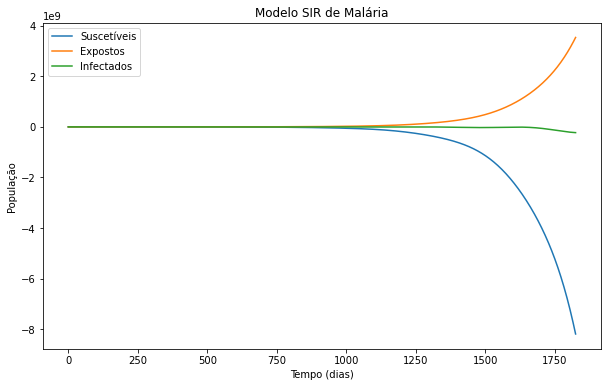

In [37]:
# B=B0, 2, 1, 0, 0.5

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -0.2, -0.75, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [38]:
S_M[-1]

-8194507582.783047

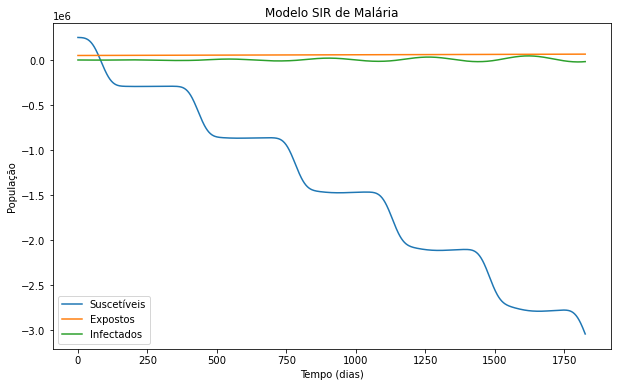

In [39]:
# A = -2, -5, -10

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -10, -0.75, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [40]:
S_M[-1]

-3041339.885518818

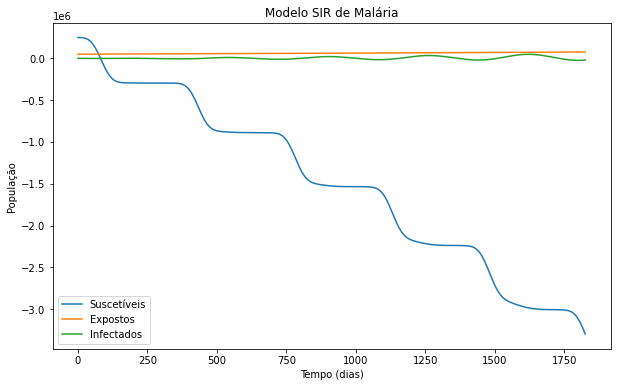

In [41]:
# B=100

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -10, 100, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [42]:
S_M[-1]

-3297938.5911278795

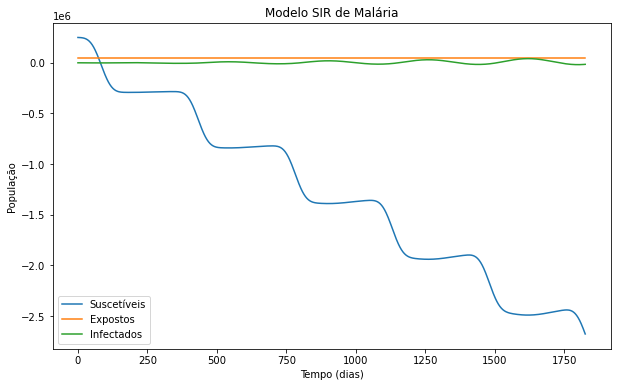

In [43]:
#C = C0, -1

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -1000000, 100, -100, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [44]:
S_M[-1]

-2676507.6329191183

In [45]:
def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))

In [46]:
p(26.4)

0.8977942234679254

In [47]:
A

-0.0300000000000000

In [48]:
B

1.31000000000000

In [49]:
C

-4.40000000000000

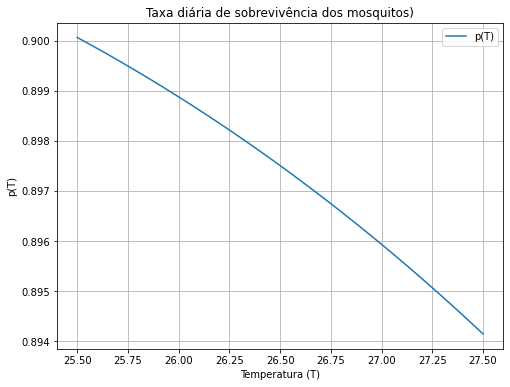

In [50]:
# Crie um intervalo de valores para a temperatura T
T_values = np.linspace(25.5, 27.5, 100)  # Intervalo de 10 a 40, com 100 pontos

# Calcule os valores correspondentes de p(T) para cada valor de T
p_values = np.exp(-1 / (A * T_values**2 + B * T_values + C))

# Plote o gráfico de p(T)
plt.figure(figsize=(8, 6))
plt.plot(T_values, p_values, label='p(T)')
plt.xlabel('Temperatura (T)')
plt.ylabel('p(T)')
plt.title('Taxa diária de sobrevivência dos mosquitos)')
plt.legend()
plt.grid(True)
plt.show()

<>:9: DeprecationWarning: invalid escape sequence \m
<>:11: DeprecationWarning: invalid escape sequence \m
<>:9: DeprecationWarning: invalid escape sequence \m
<>:11: DeprecationWarning: invalid escape sequence \m
<>:9: DeprecationWarning: invalid escape sequence \m
<>:11: DeprecationWarning: invalid escape sequence \m
<ipython-input-51-6a84b7aed4b4>:9: DeprecationWarning: invalid escape sequence \m
  plt.plot(T_values, mu_values, label='\mu(T)')
<ipython-input-51-6a84b7aed4b4>:11: DeprecationWarning: invalid escape sequence \m
  plt.ylabel('\mu(T)')


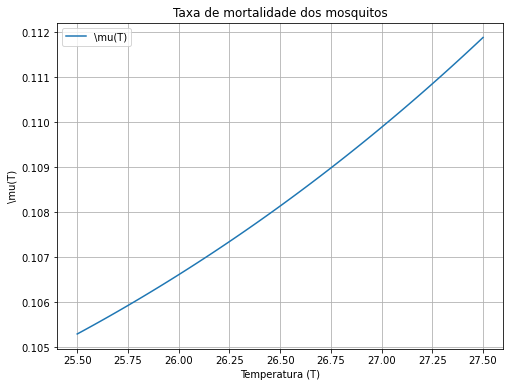

In [51]:
# Intervalo de valores para a temperatura T
T_values = np.linspace(25.5, 27.5, 100) 

# Calcule os valores correspondentes de \mu(T) para cada valor de T
mu_values = [-log(np.exp(-1 / (A * T**2 + B * T + C))) for T in T_values]

# Plote o gráfico de \mu(T)
plt.figure(figsize=(8, 6))
plt.plot(T_values, mu_values, label='\mu(T)')
plt.xlabel('Temperatura (T)')
plt.ylabel('\mu(T)')
plt.title('Taxa de mortalidade dos mosquitos')
plt.legend()
plt.grid(True)
plt.show()

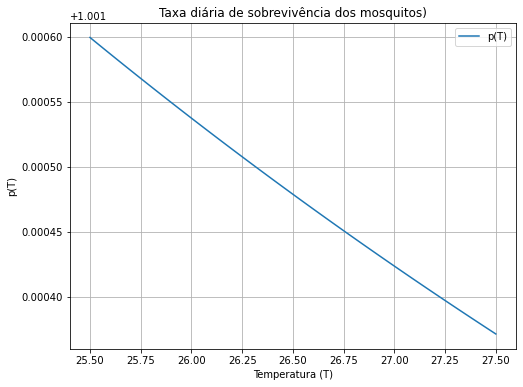

In [52]:
A=-1
B=1
C=-1

# Crie um intervalo de valores para a temperatura T
T_values = np.linspace(25.5, 27.5, 100)  # Intervalo de 10 a 40, com 100 pontos

# Calcule os valores correspondentes de p(T) para cada valor de T
p_values = np.exp(-1 / (A * T_values**2 + B * T_values + C))

# Plote o gráfico de p(T)
plt.figure(figsize=(8, 6))
plt.plot(T_values, p_values, label='p(T)')
plt.xlabel('Temperatura (T)')
plt.ylabel('p(T)')
plt.title('Taxa diária de sobrevivência dos mosquitos)')
plt.legend()
plt.grid(True)
plt.show()

<>:9: DeprecationWarning: invalid escape sequence \m
<>:11: DeprecationWarning: invalid escape sequence \m
<>:9: DeprecationWarning: invalid escape sequence \m
<>:11: DeprecationWarning: invalid escape sequence \m
<>:9: DeprecationWarning: invalid escape sequence \m
<>:11: DeprecationWarning: invalid escape sequence \m
<ipython-input-53-6a84b7aed4b4>:9: DeprecationWarning: invalid escape sequence \m
  plt.plot(T_values, mu_values, label='\mu(T)')
<ipython-input-53-6a84b7aed4b4>:11: DeprecationWarning: invalid escape sequence \m
  plt.ylabel('\mu(T)')


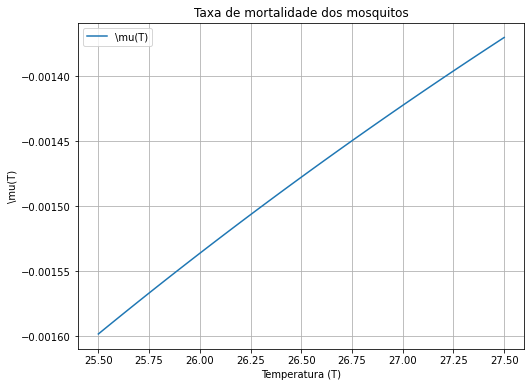

In [53]:
# Intervalo de valores para a temperatura T
T_values = np.linspace(25.5, 27.5, 100) 

# Calcule os valores correspondentes de \mu(T) para cada valor de T
mu_values = [-log(np.exp(-1 / (A * T**2 + B * T + C))) for T in T_values]

# Plote o gráfico de \mu(T)
plt.figure(figsize=(8, 6))
plt.plot(T_values, mu_values, label='\mu(T)')
plt.xlabel('Temperatura (T)')
plt.ylabel('\mu(T)')
plt.title('Taxa de mortalidade dos mosquitos')
plt.legend()
plt.grid(True)
plt.show()

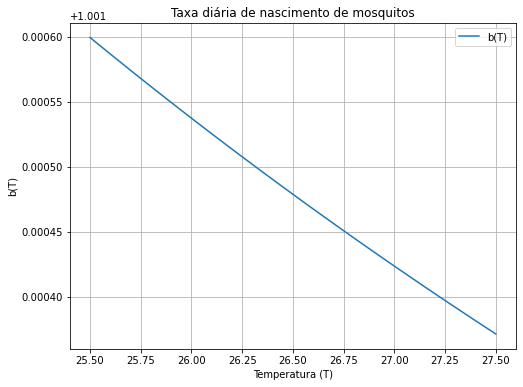

In [54]:
def tau_L(Temp):
        return 1 / (c1 * Temp + c2)

# Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
def p_LT(Temp):
    return np.exp(-(c1 * Temp + c2))

def p_LR(Rain):
    return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
def p_LRT(Rain,Temp):
    return p_LR(Rain)*p_LT(Temp)
    
# Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
def p_ER(Rain):
    return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
# Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
def p_PR(Rain):
    return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

# Crie um intervalo de valores para a temperatura T
T_values = np.linspace(25.5, 27.5, 100) 

# Crie um intervalo de valores para a temperatura T
R_values = np.linspace(100, 400, 100) 

# Calcule os valores correspondentes de b(T) para cada valor de T
b_values = B_E * p_ER(R_values) * p_LRT(R_values, T_values) * p_PR(R_values) / (tau_E + tau_L(T_values) + tau_P)

plt.figure(figsize=(8, 6))
plt.plot(T_values, p_values, label='b(T)')
plt.xlabel('Temperatura (T)')
plt.ylabel('b(T)')
plt.title('Taxa diária de nascimento de mosquitos')
plt.legend()
plt.grid(True)
plt.show()

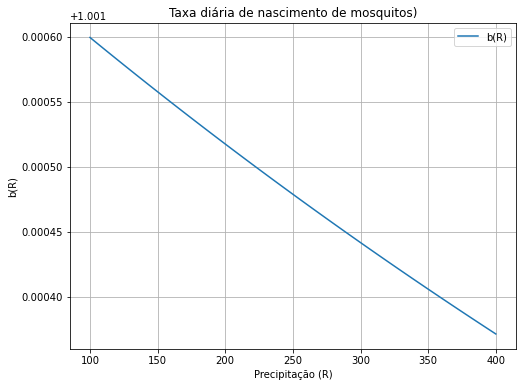

In [55]:
plt.figure(figsize=(8, 6))
plt.plot(R_values, p_values, label='b(R)')
plt.xlabel('Precipitação (R)')
plt.ylabel('b(R)')
plt.title('Taxa diária de nascimento de mosquitos)')
plt.legend()
plt.grid(True)
plt.show()

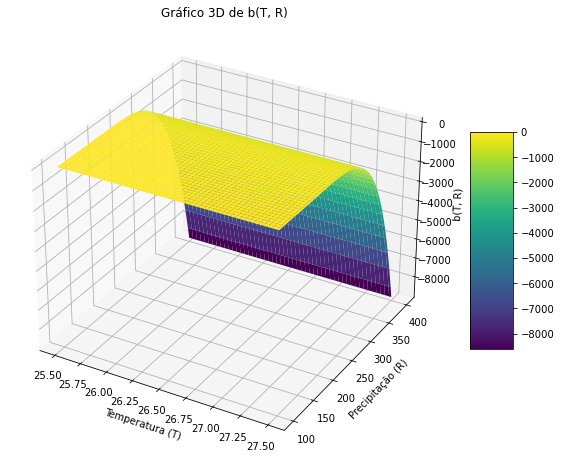

In [57]:
T, R = np.meshgrid(T_values, R_values)

# Calcule os valores correspondentes de b(T, R) para cada par de T e R
def calculate_b(T, R):
    return B_E * p_ER(R) * p_LRT(R, T) * p_PR(R) / (tau_E + tau_L(T) + tau_P)

b_values = calculate_b(T, R)

# Crie um gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection='3d')

# Plote o gráfico 3D
surf = ax.plot_surface(T, R, b_values, cmap='viridis')
ax.set_xlabel('Temperatura (T)')
ax.set_ylabel('Precipitação (R)')
ax.set_zlabel('b(T, R)')
ax.set_title('Gráfico 3D de b(T, R)')

# Adicione uma barra de cores para visualização
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()